In [1]:
!ls

 DengAI.ipynb			     Iquitos.ipynb
'Dengue Data Visualizations.ipynb'  'San Juan.ipynb'
 dengue_features_test.csv	     submission1.csv
 dengue_features_train.csv	     submission_format.csv
 dengue_labels_train.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [5]:
matplotlib.rcParams['figure.figsize'] = (20, 20)

In [6]:
X_orig = pd.read_csv('dengue_features_train.csv')
Y_orig = pd.read_csv('dengue_labels_train.csv')

In [7]:
iquitos = X_orig['city'] == 'iq'
X = X_orig[iquitos]
y = Y_orig[iquitos]['total_cases']
data = pd.concat([X, y], axis=1)

In [8]:
X.shape, y.shape, data.shape

((520, 24), (520,), (520, 25))

# Visualizations 

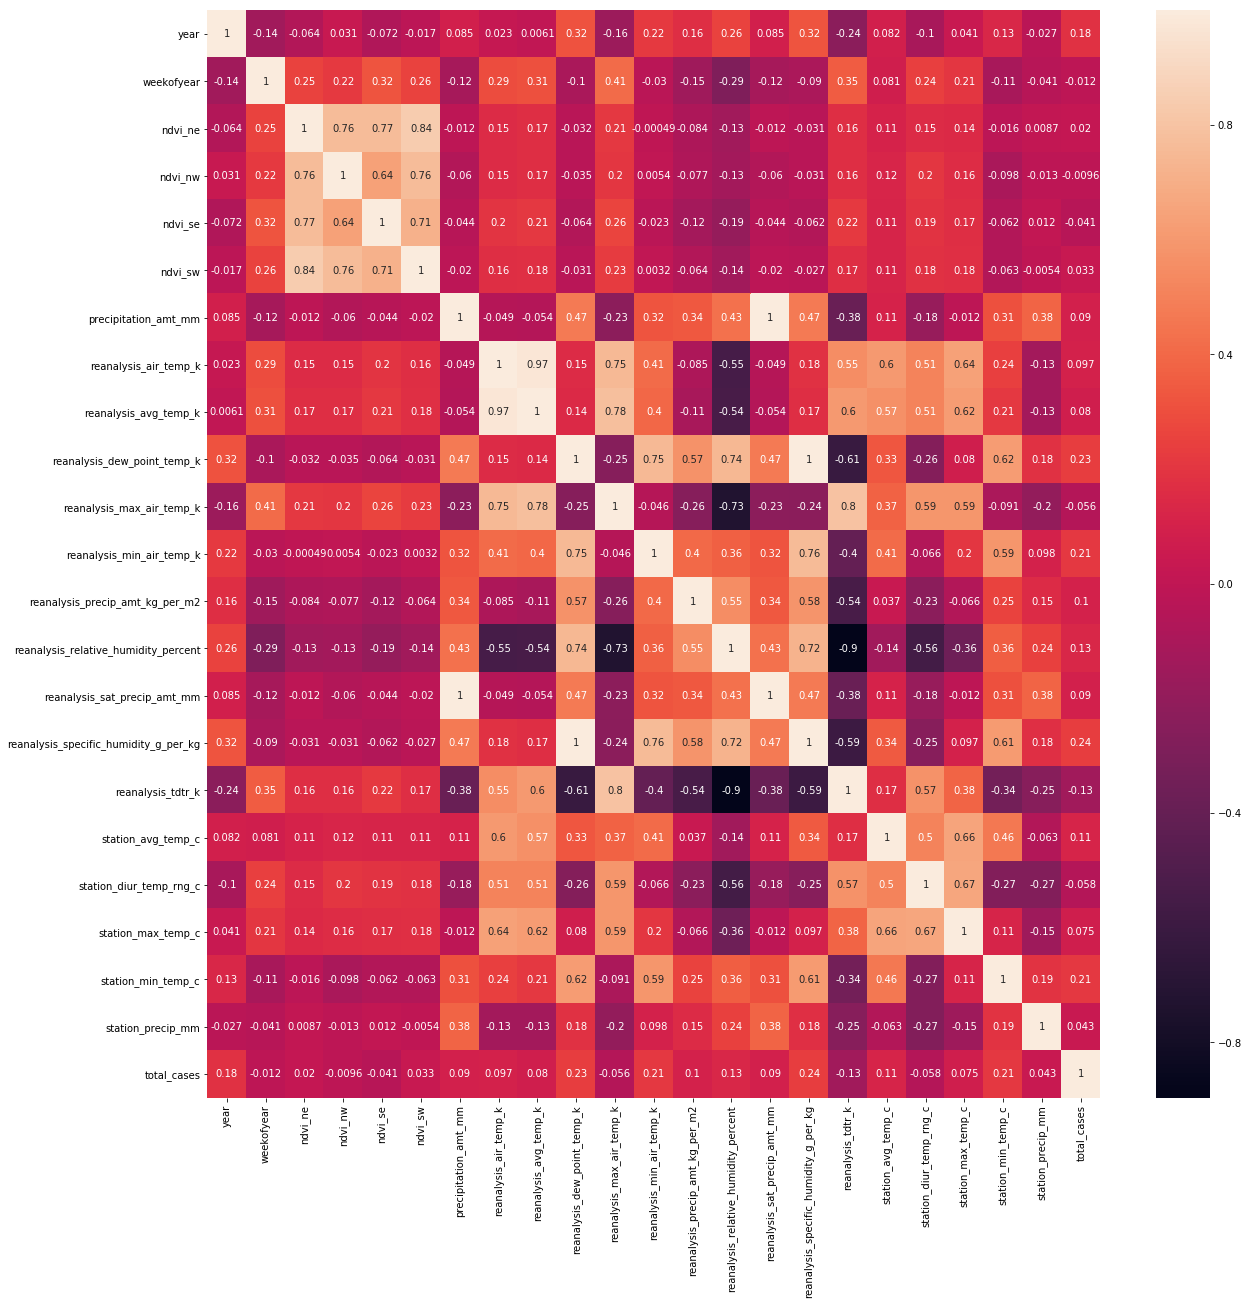

In [9]:
sns.heatmap(data.corr(), annot=True)

# Transformations

In [10]:
ndvi_feature_names = list(filter(lambda s: s.startswith(r'ndvi'), list(X.columns)))
reanalysis_feature_names = list(filter(lambda s: s.startswith(r'reanalysis'), list(X.columns)))
station_feature_names = list(filter(lambda s: s.startswith('station'), list(X.columns)))

numerical_features = ndvi_feature_names + reanalysis_feature_names + station_feature_names

In [11]:
def remove_poorly_correlated_features(df):
    return df

def add_historical_values(df):
    historical_data = df[numerical_features].rolling(4).mean().fillna(method="bfill")
    column_rename = lambda name: 'past_' + name
    historical_data.columns = map(column_rename, historical_data.columns)
    return pd.concat([df, historical_data], axis=1)

def fill_missing_values(df):
    new_df = df.fillna(df.mean())
    return new_df

def drop_unwanted_variables(df):
    new_df = df.drop(columns=['city', 'week_start_date'])
    return new_df

def apply_all_transformations(df):
    df = add_historical_values(df)
    df = fill_missing_values(df)
    df = drop_unwanted_variables(df)
    return df

In [12]:
X = apply_all_transformations(X)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Random Forest

In [34]:
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)
forest.score(X_train, y_train), forest.score(X_test, y_test)

(0.849806680684795, 0.06600467289719647)

In [35]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(forest.predict(X_test), y_test)

5.7823076923076915

In [36]:
for i in [13, 53, 69, 2342]:
    forest = RandomForestRegressor(random_state=i)
    print(cross_val_score(forest, X, y, scoring='neg_mean_absolute_error'))

[-8.34770115 -6.73757225 -7.9734104 ]
[-9.30402299 -7.05433526 -7.60578035]
[-9.42816092 -7.25202312 -7.65202312]
[-8.78103448 -7.59537572 -7.9566474 ]


# Decision Tree 

In [44]:
tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [45]:
tree.score(X_train, y_train), tree.score(X_test, y_test)

(1.0, -1.1730829861502086)

In [50]:
cross_val_score(tree, X, y, cv=4)

array([-1.46825547, -0.43649658, -3.49684566, -0.67455813])

In [51]:
cross_val_score(tree, X, y, cv=4, scoring='neg_mean_absolute_error')

array([ -8.20769231, -10.2       ,  -9.56923077, -10.20769231])

# Lasso 

In [47]:
lasso = Lasso(random_state=42)
lasso.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False)

In [49]:
lasso.score(X_train, y_train), lasso.score(X_test, y_test)

(0.11341567184202228, 0.023246741430681835)

In [53]:
cross_val_score(lasso, X, y)

array([-0.32007669,  0.00370392, -0.06710359])

In [54]:
cross_val_score(lasso, X, y, scoring='neg_mean_absolute_error')

array([-7.34295098, -6.07681289, -7.74768695])